In [39]:
# modules
import os
import pyproj
import fnmatch
import matplotlib
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from geocube.api.core import make_geocube
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
%matplotlib inline

In [40]:
# Store the name of the 'active' file in a variable
controlFile = 'control_Yukon_Merit.txt'

In [41]:
# Easy access to control file folder
controlFolder = Path('../0_control_files')

In [42]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [43]:
# mizuRoute simulations
mizu_output_path = Path('/Users/darrieythorsson/compHydro/data/CWARHM_data/domain_Yukon/simulations/run_Yukon_Merit/mizuRoute')
mizu_output_name = 'run_Yukon_Merit.h.2005-12-01-00000.nc'

In [44]:
# SUMMA simulations
summa_output_path = Path('/Users/darrieythorsson/compHydro/data/CWARHM_data/domain_Yukon/simulations/run_Yukon_Merit_1/SUMMA')
summa_output_name = 'run_1_Yukon_Merit_day.nc'

## Get list of snow observation sites

In [45]:
snow_list_path = '/Users/darrieythorsson/compHydro/data/CWARHM_data/domain_Yukon/observations/Yukon_Merit_basins_with_SWEobs.csv'

In [46]:
ds_snow_list = pd.read_csv(snow_list_path)

COMID    unitarea  center_lon  center_lat      HRU_area     station_id  \
0   81015447    9.547679    -141.212      64.783  1.057147e+07           1189   
1   81006845   32.258877    -151.553      66.928  3.412068e+07           1182   
2   81015349   14.506439    -147.232      64.771  1.573210e+07           1260   
3   81025019   86.062566    -142.098      62.109  9.706865e+07           1093   
4   81006886   37.447005    -150.225      67.240  3.969014e+07            958   
..       ...         ...         ...         ...           ...            ...   
80  81025402   58.468443    -137.120      61.994  6.745323e+07   YT-09CA-SC01   
81  81027356   39.737109    -137.385      61.700  4.592631e+07   YT-09CA-SC02   
82  81026612   30.087944    -139.085      61.350  3.462852e+07   YT-09CA-SC03   
83  81023388   42.560482    -135.825      63.636  4.855497e+07  YT-09DC-SC01B   
84  81016648  126.867493    -135.302      63.924  1.446054e+08   YT-09DD-SC01   

          lat        lon  elevation             station_na Country  
0   64.790000 -141.23000     1050.0  American Creek (1189)     USA  
1   66.920000 -151.53000      640.0   Bettles Field (1182)     USA  
2   64.760000 -147.22000      500.0     Chena Lakes (1260)     USA  
3   62.070000 -142.05000     3320.0         Chisana (1093)     USA  
4   67.250000 -150.18000     1040.0         Coldfoot (958)     USA  
..        ...        ...        ...                    ...     ...  
80  62.024834 -137.06645     1021.0           MOUNT NANSEN     CAN  
81  61.721170 -137.33966     1160.0              MACINTOSH     CAN  
82  61.371113 -139.03305      810.0       BURWASH AIRSTRIP     CAN  
83  63.633335 -135.88333      540.0         MAYO AIRPORT B     CAN  
84  63.916668 -135.40000     1310.0                CALUMET     CAN  

[85 rows x 11 columns]

In [47]:
summa = xr.open_dataset(summa_output_path/summa_output_name)

/var/folders/pc/q8630ffx72z0bwfzz59ws0kc0000gn/T/ipykernel_35594/110553065.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


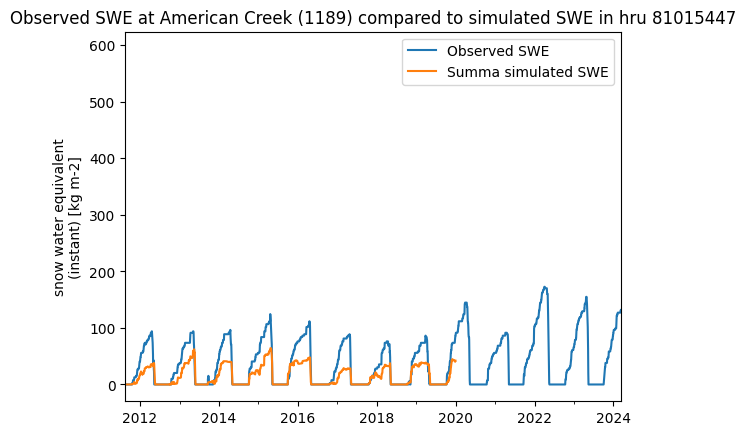

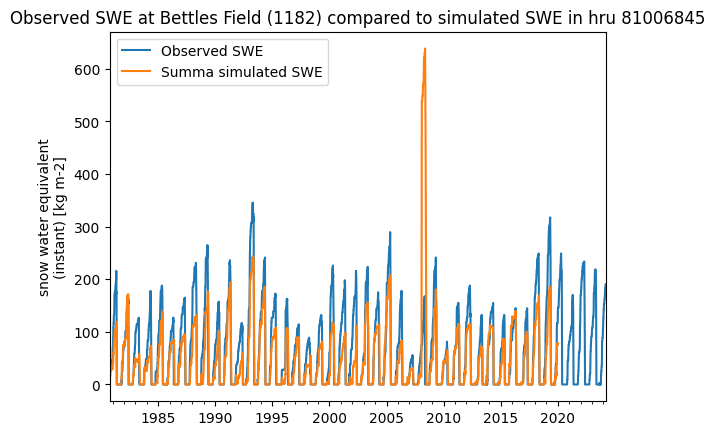

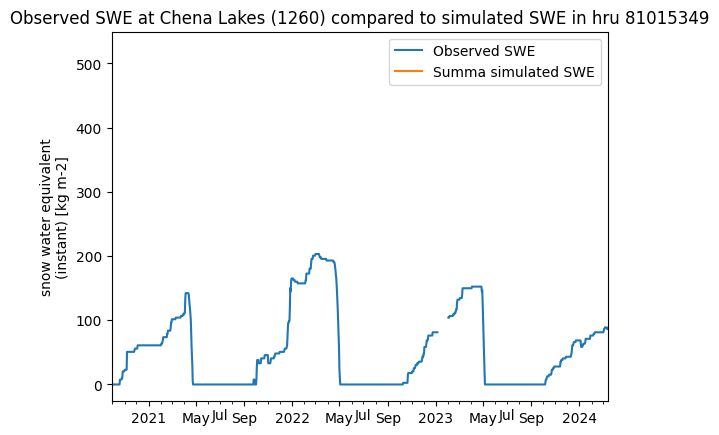

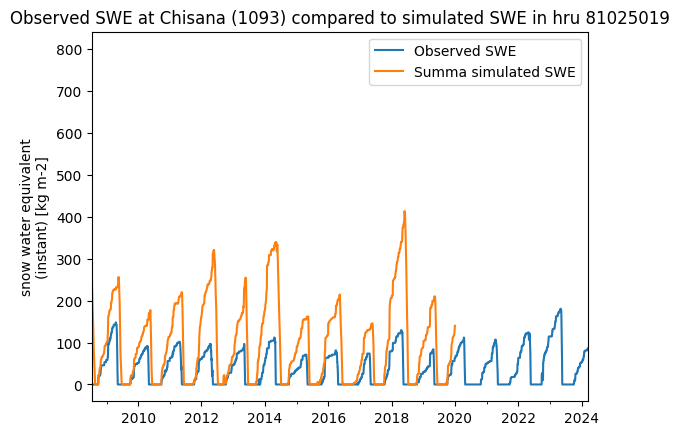

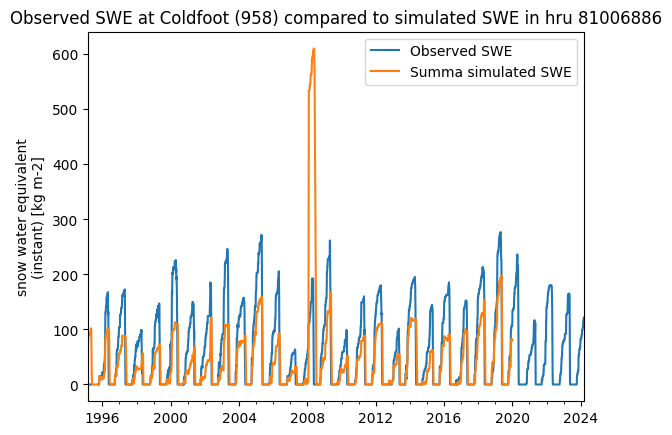

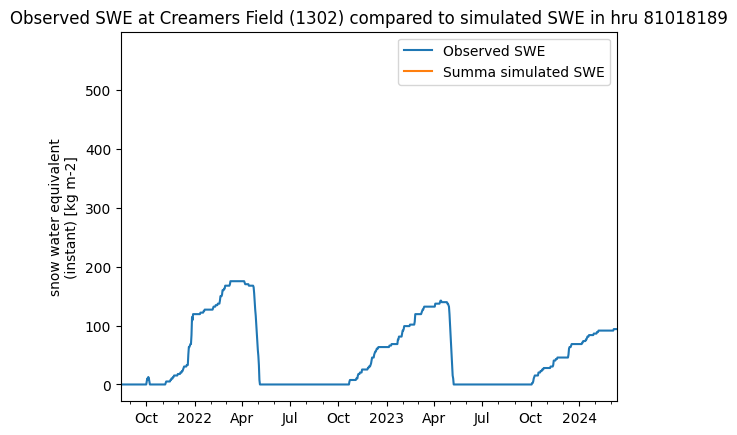

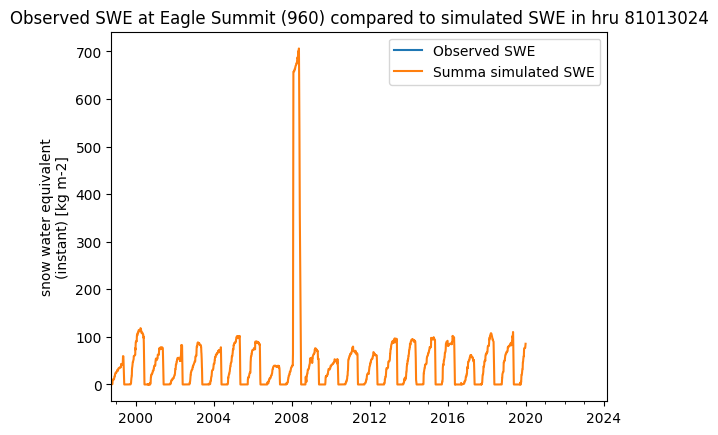

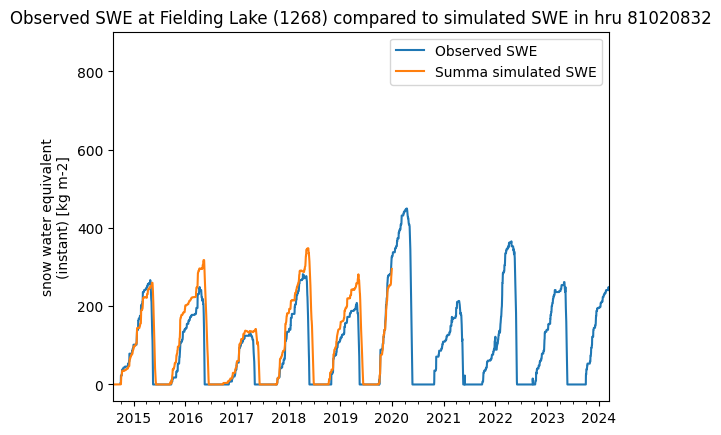

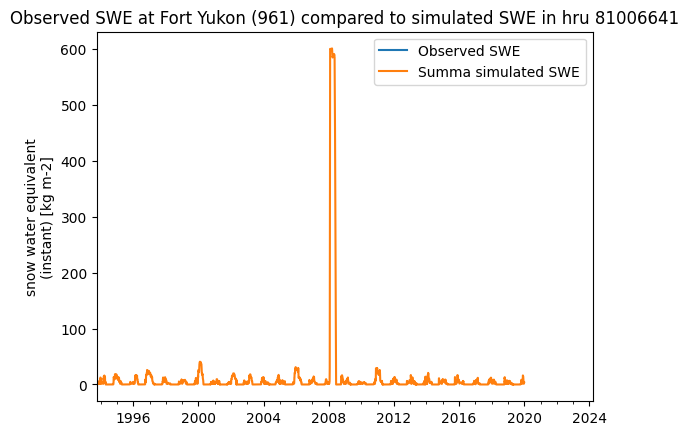

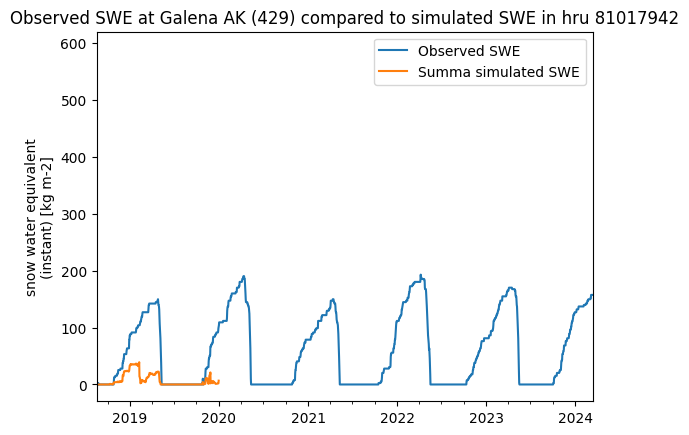

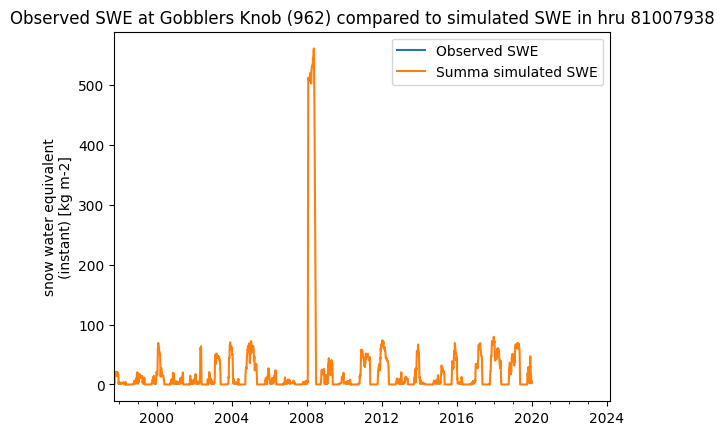

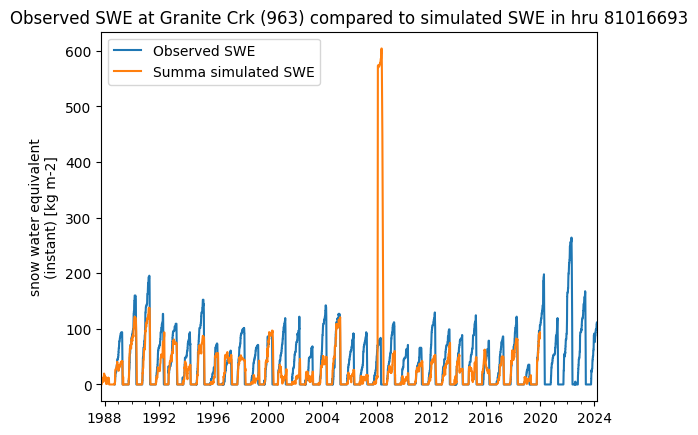

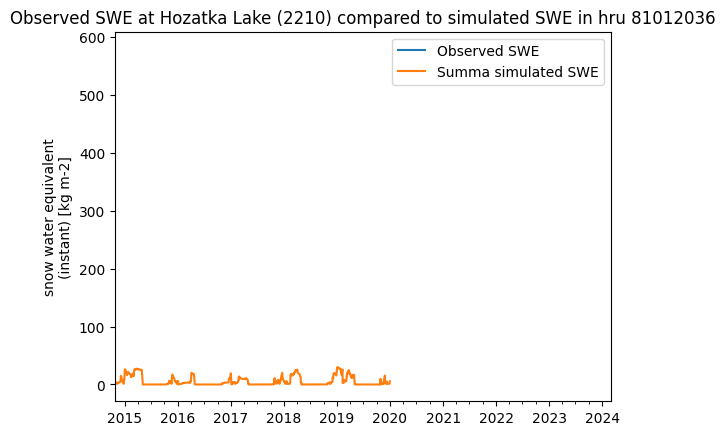

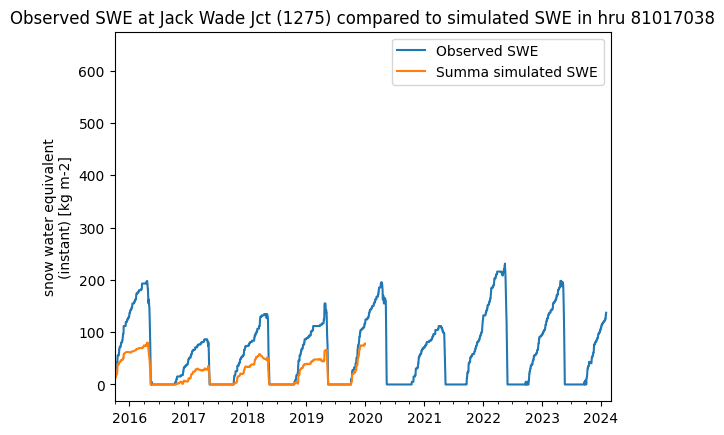

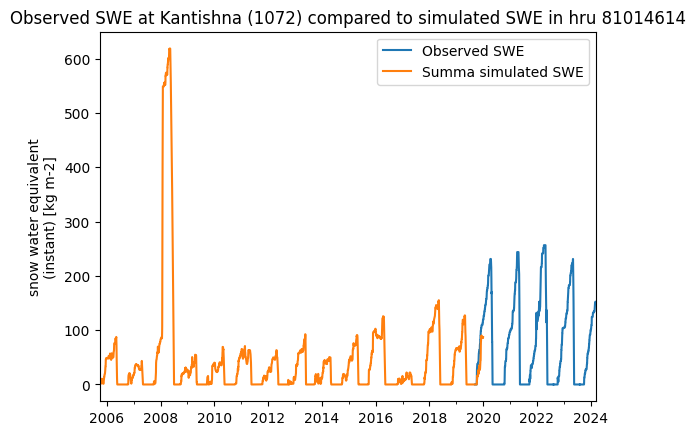

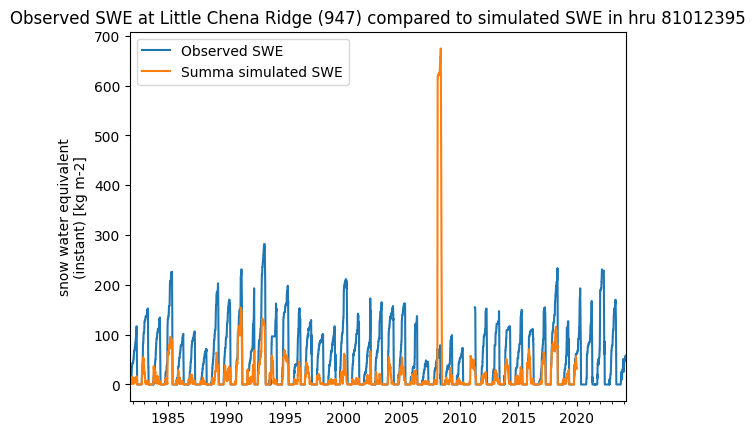

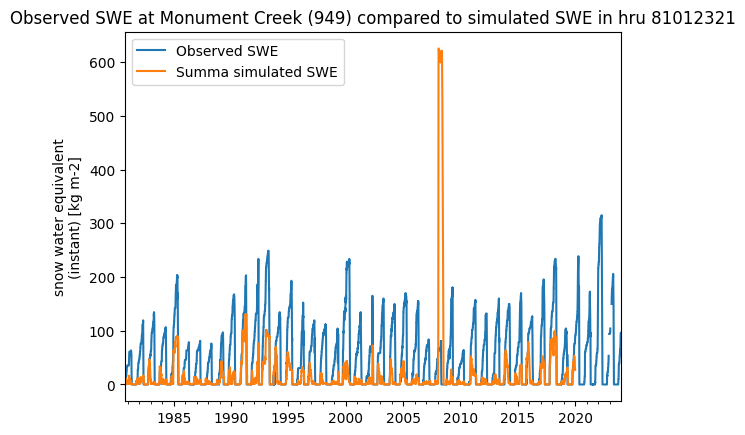

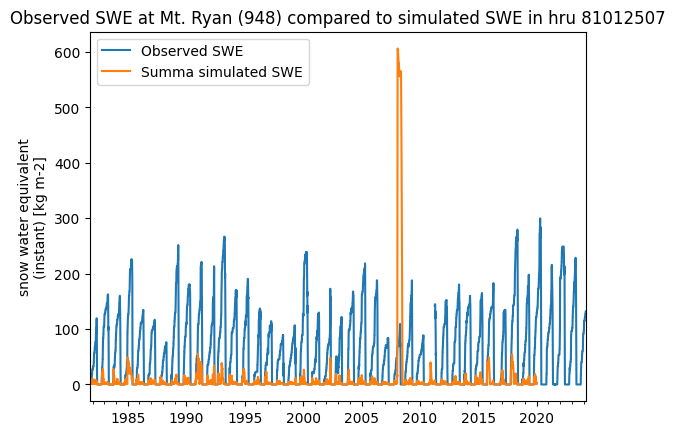

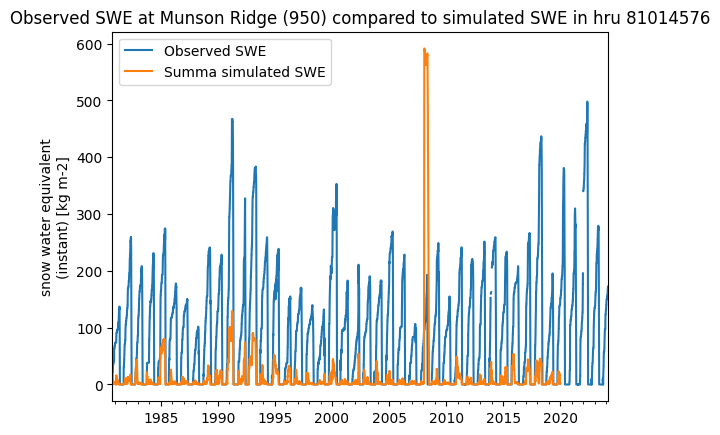

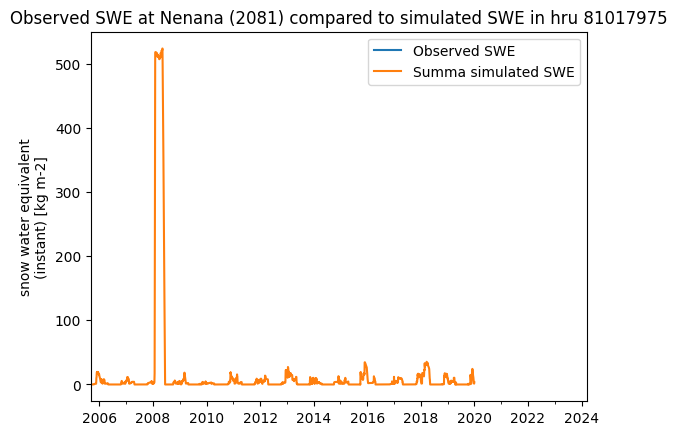

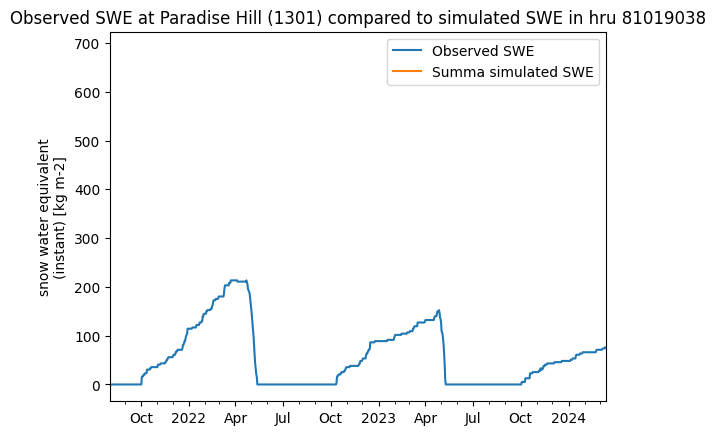

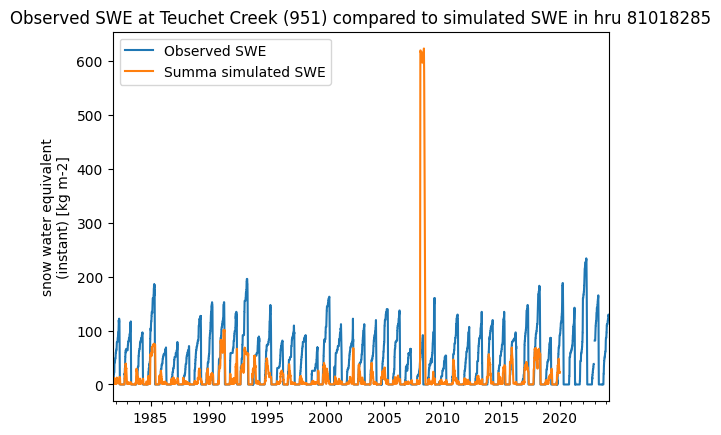

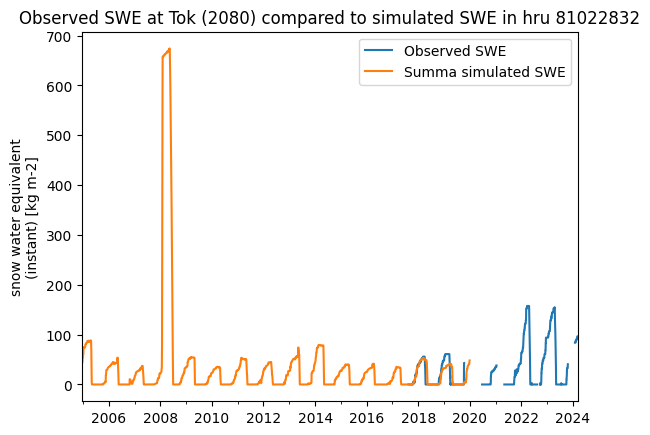

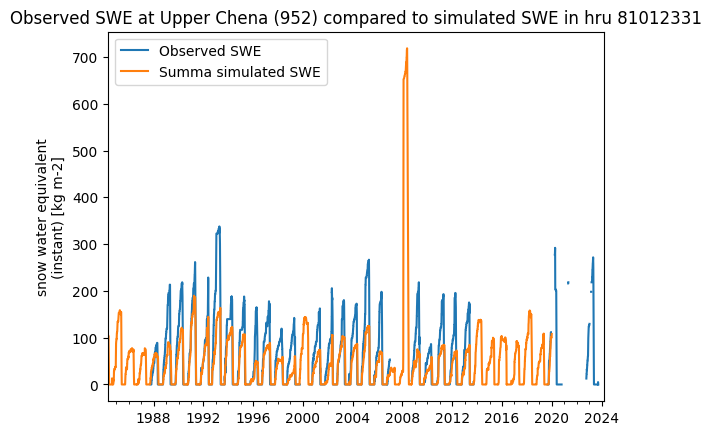

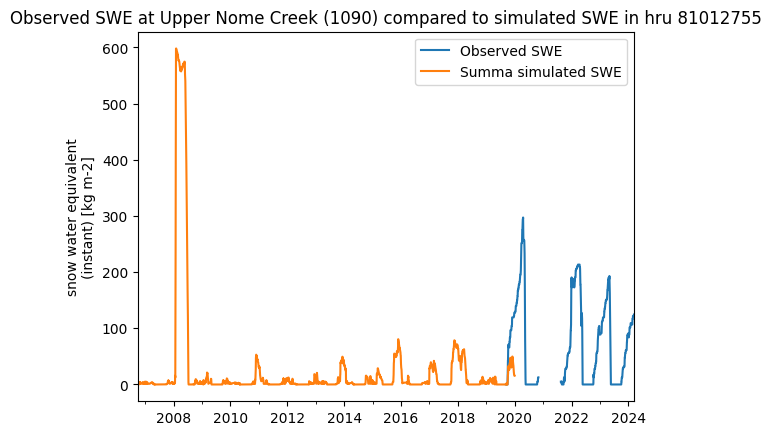

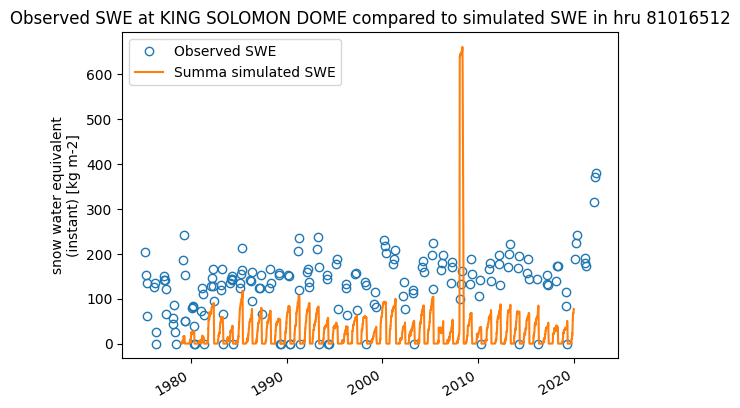

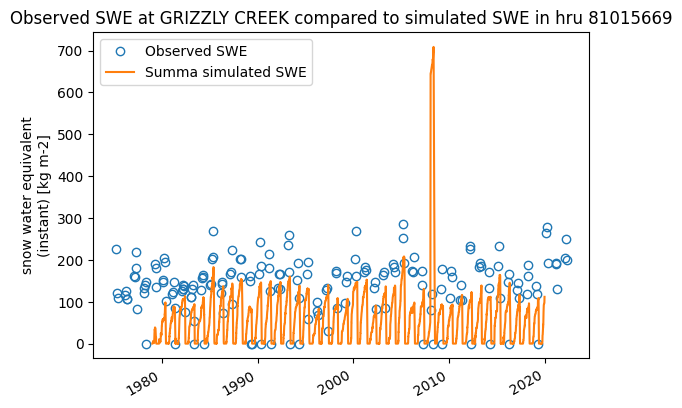

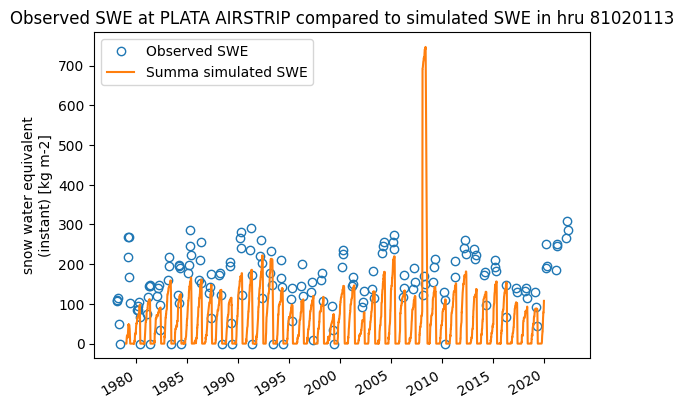

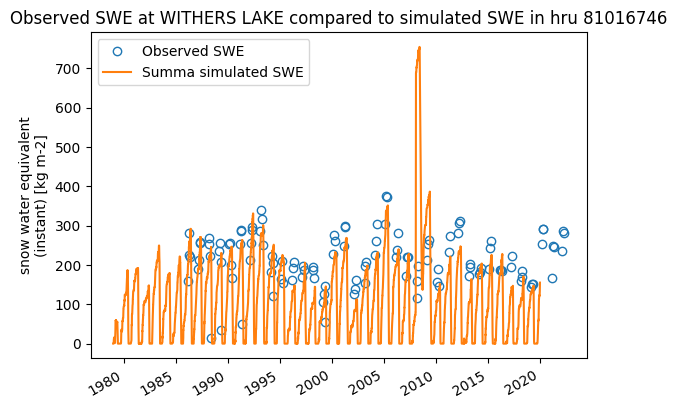

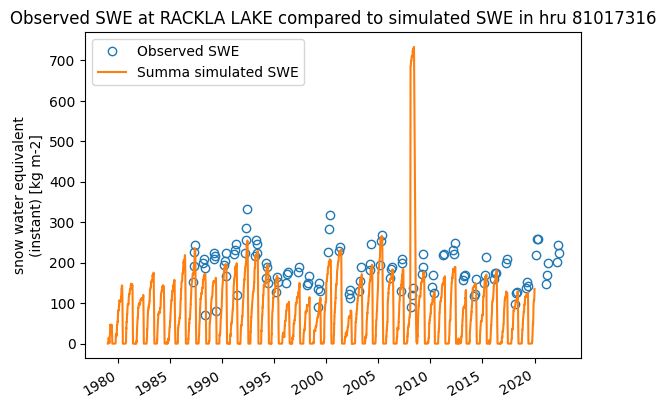

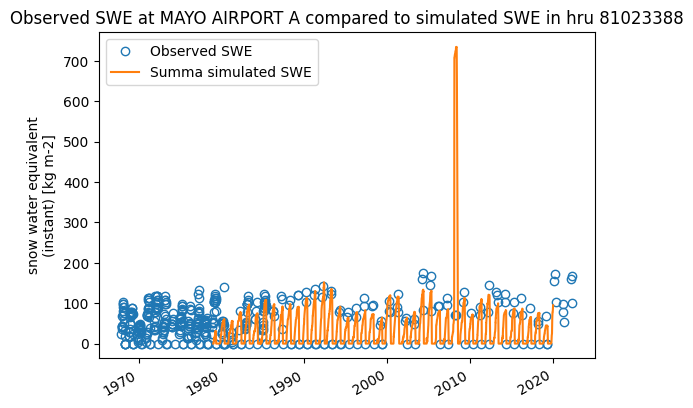

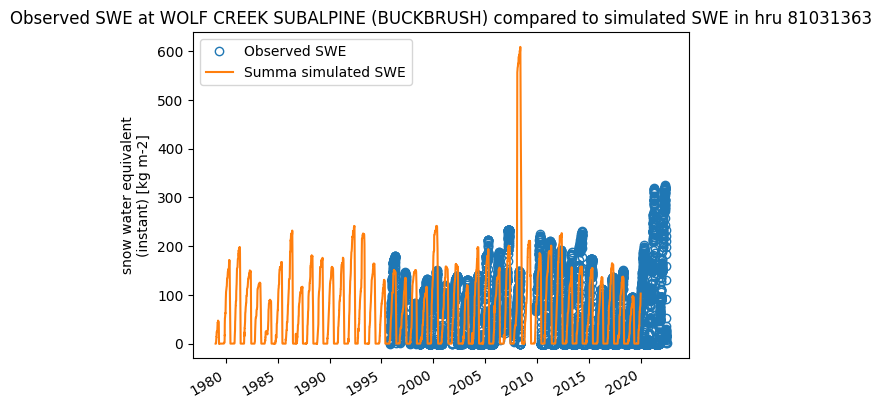

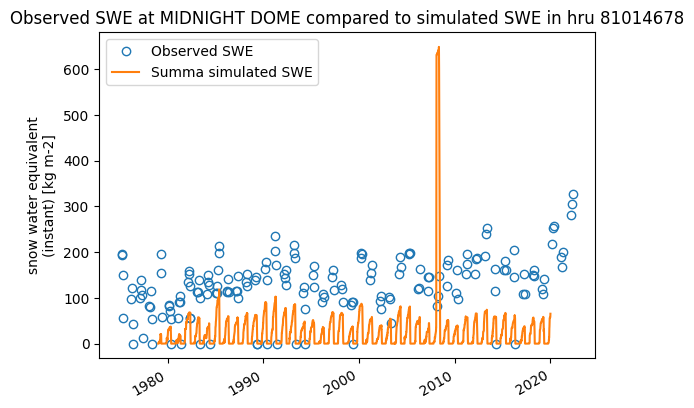

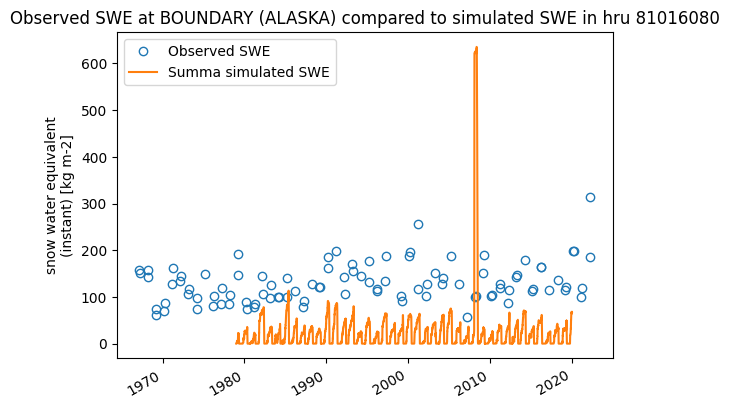

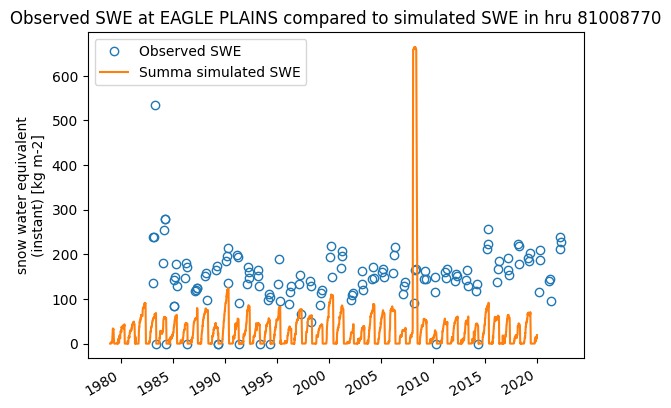

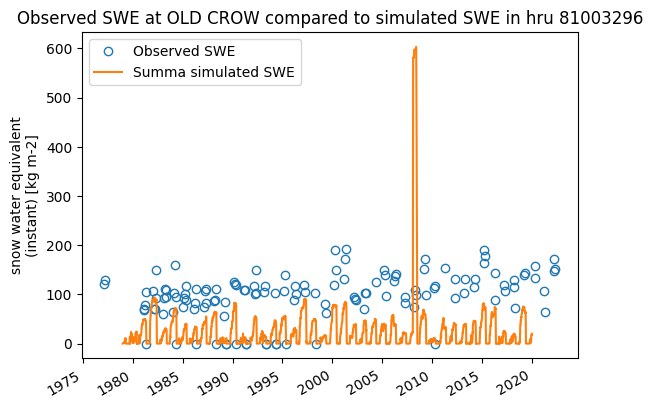

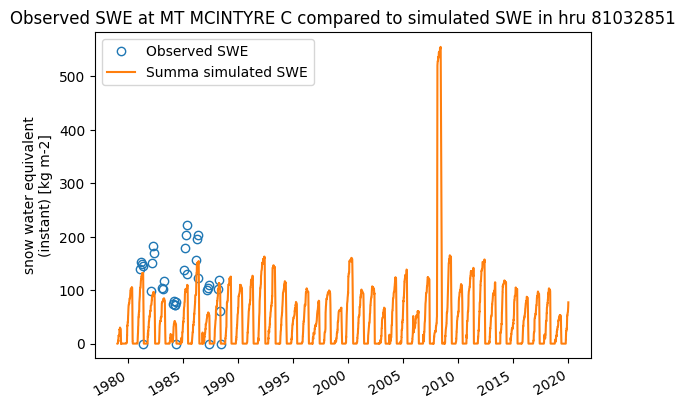

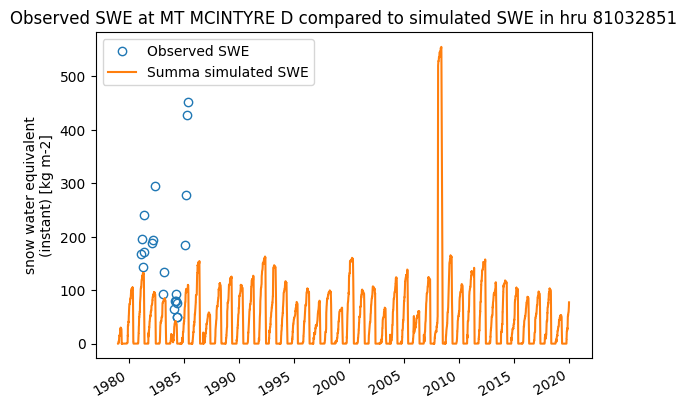

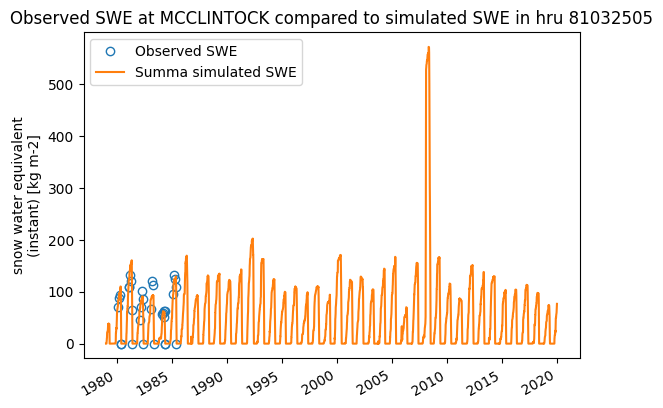

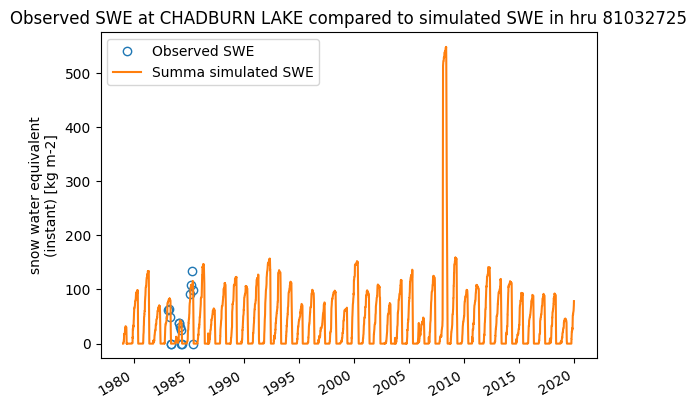

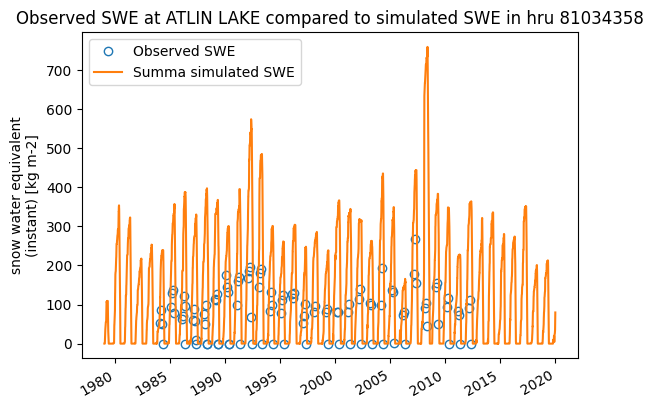

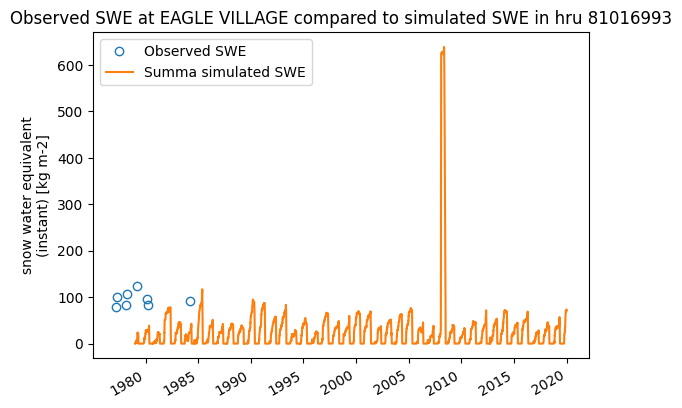

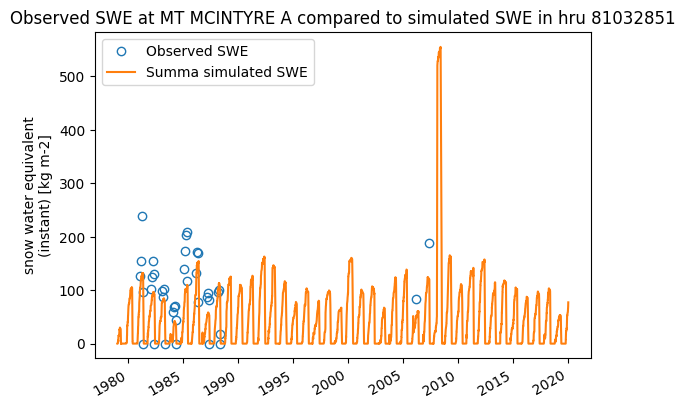

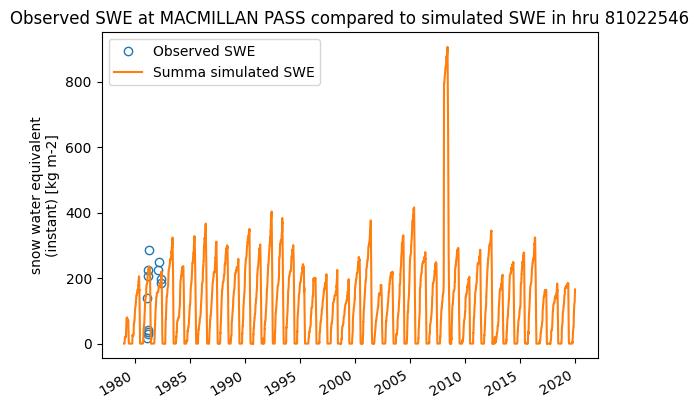

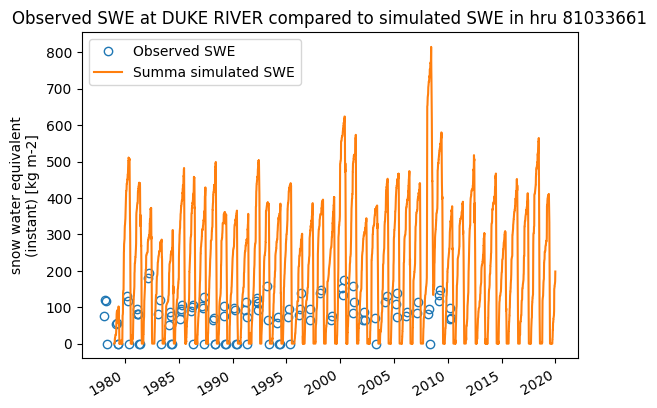

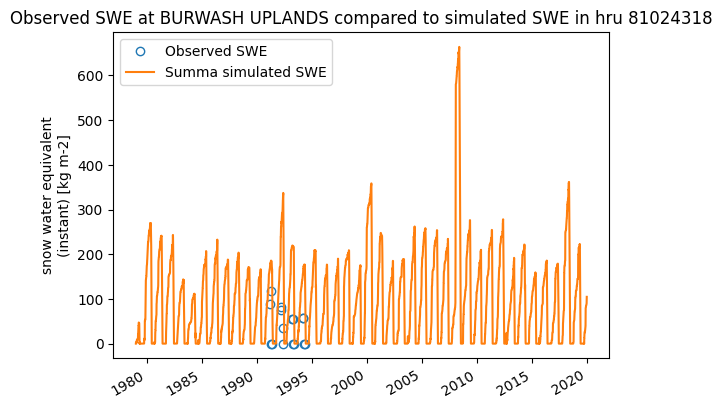

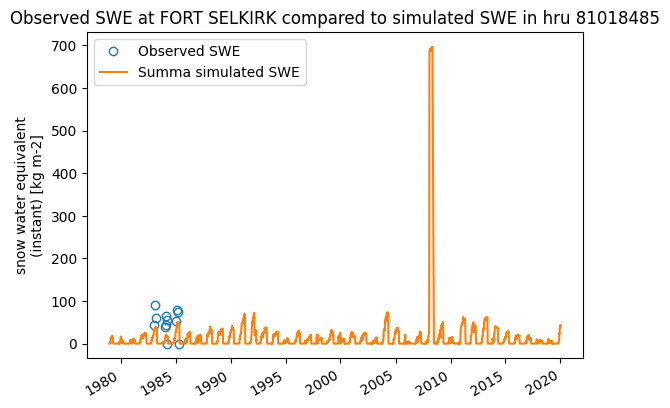

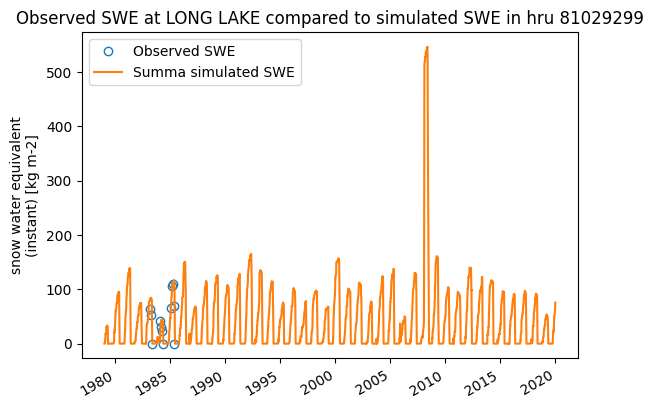

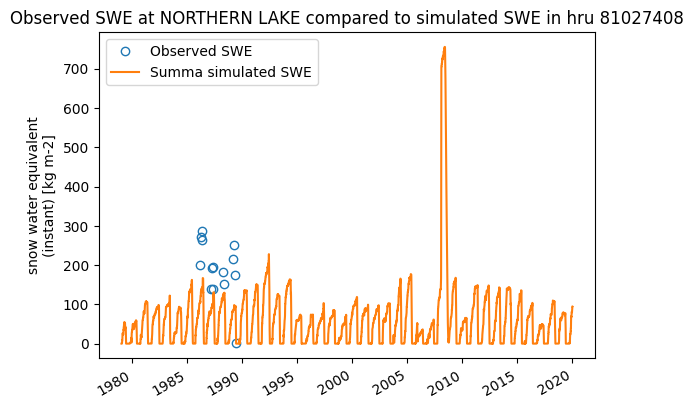

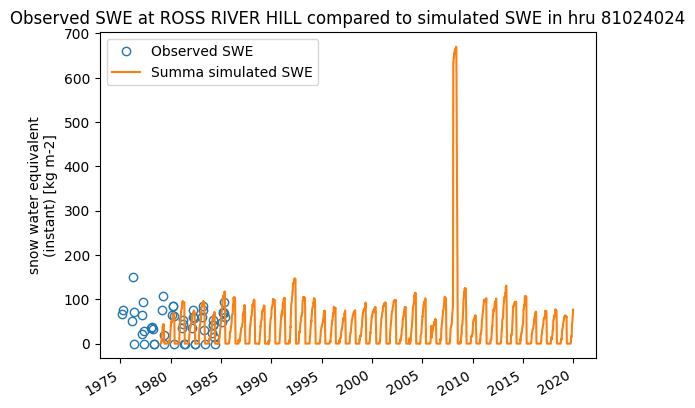

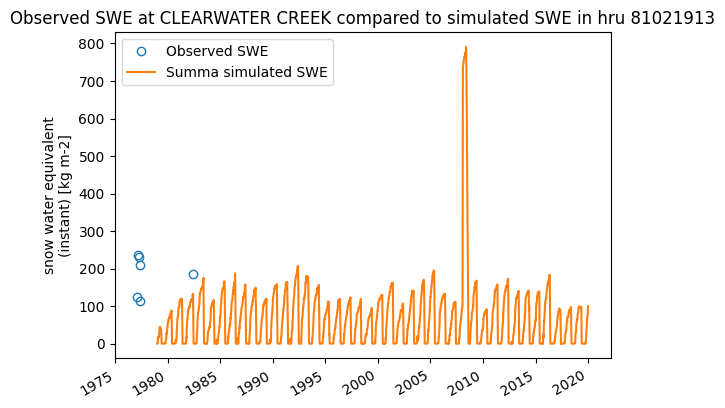

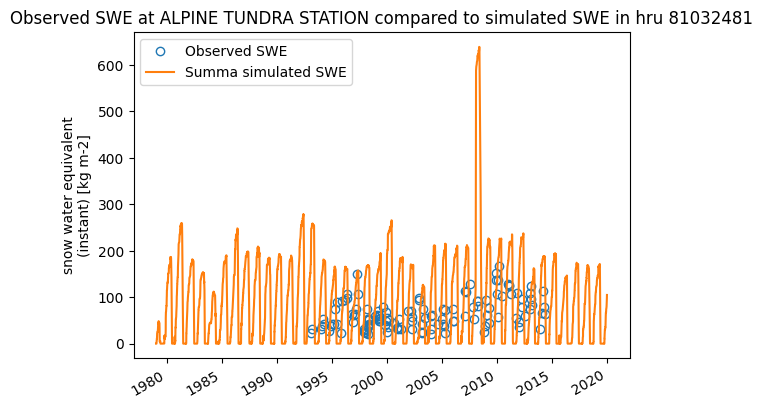

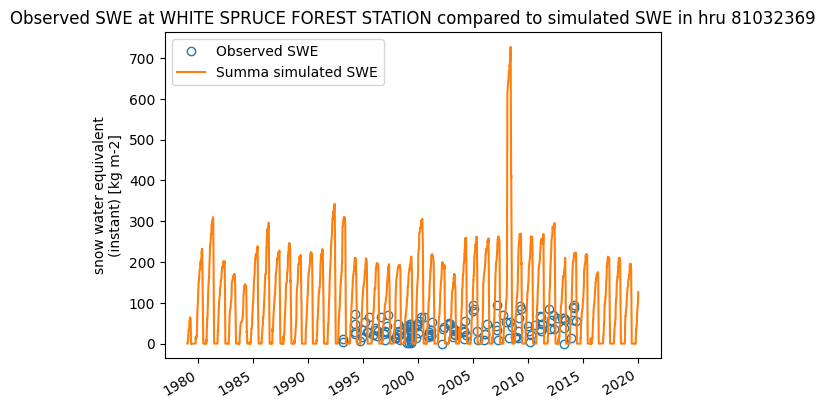

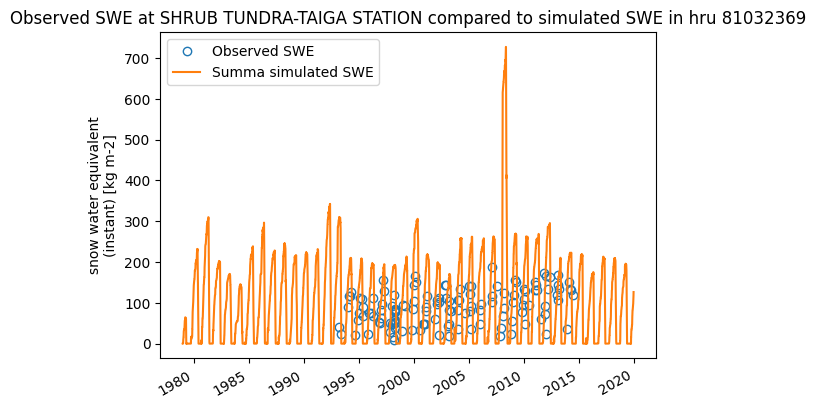

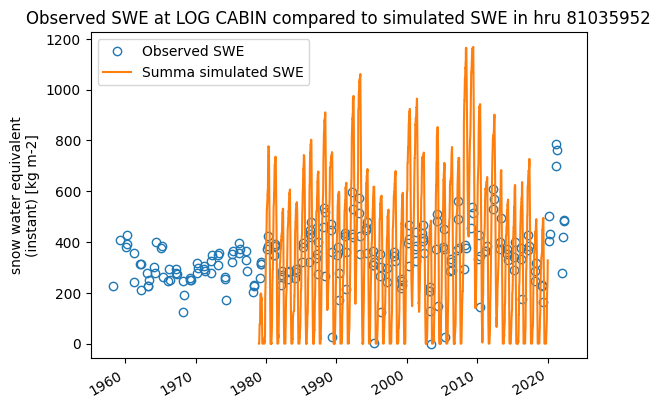

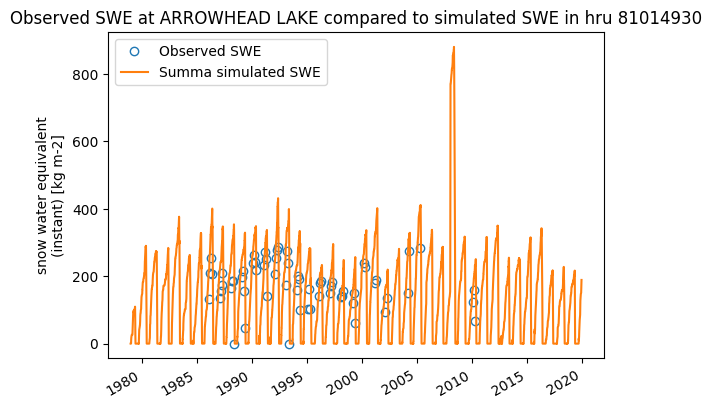

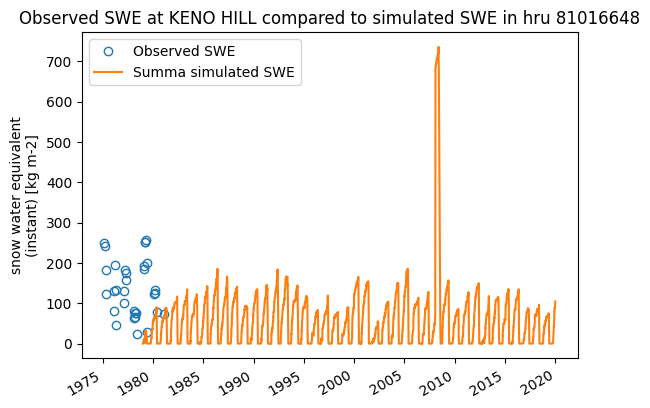

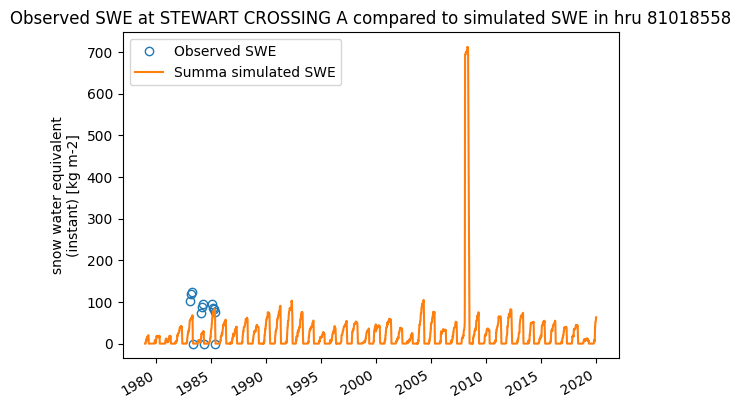

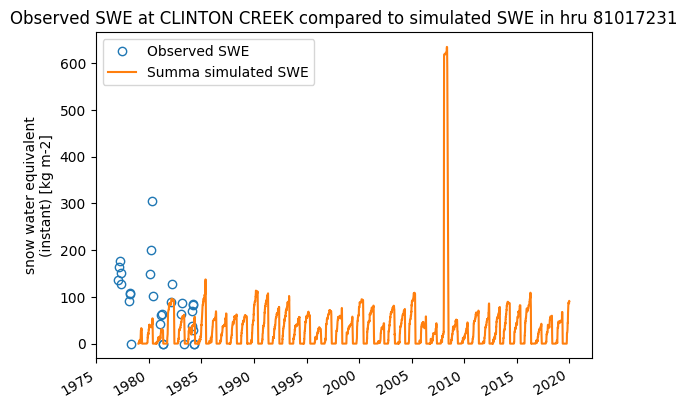

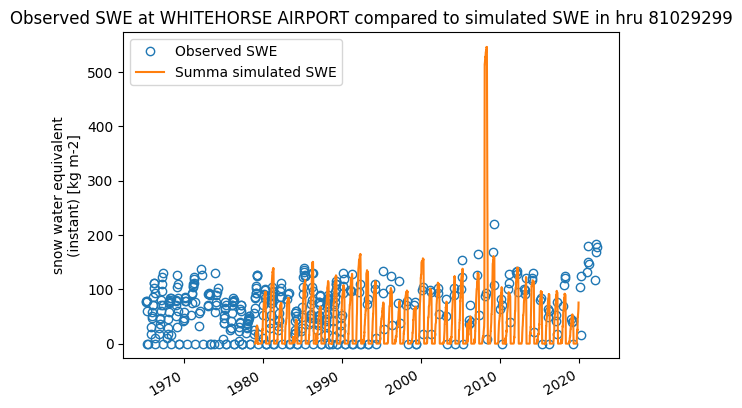

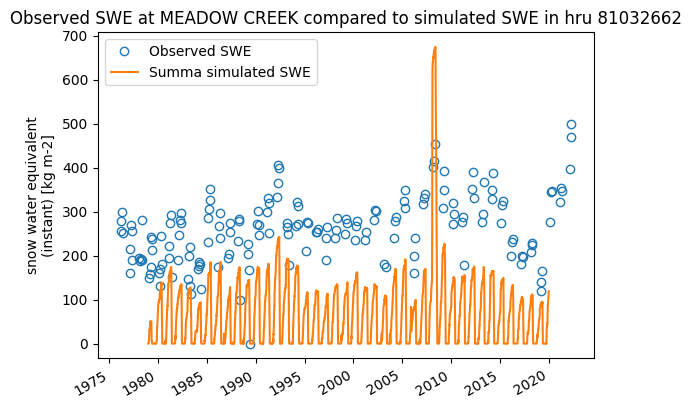

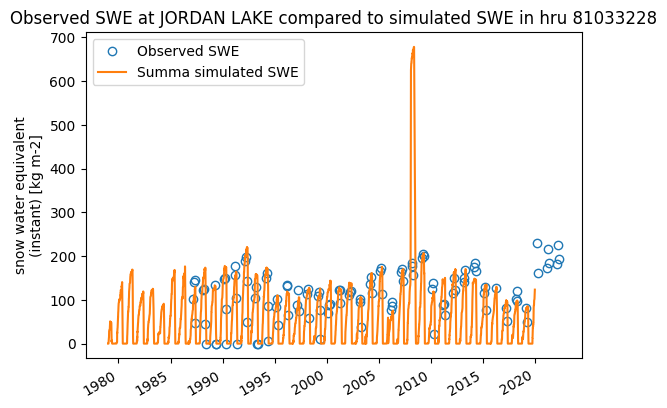

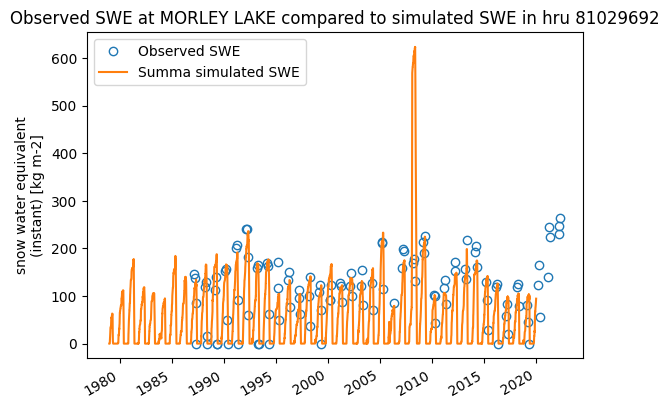

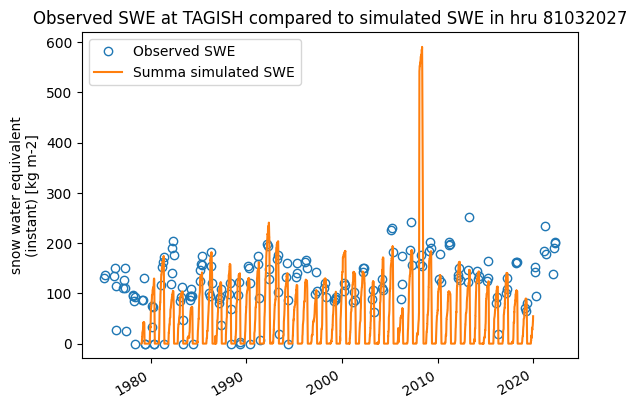

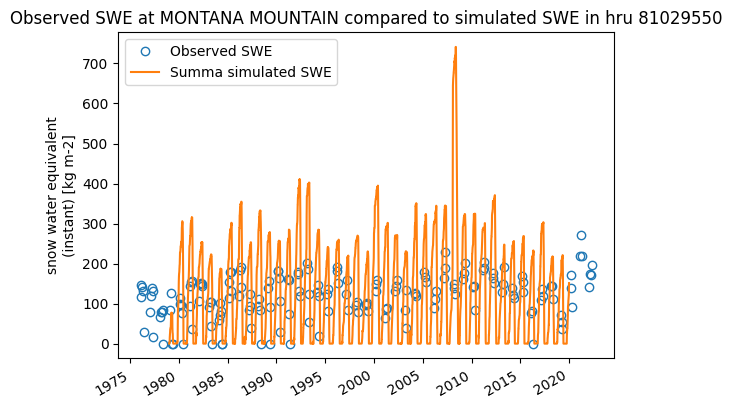

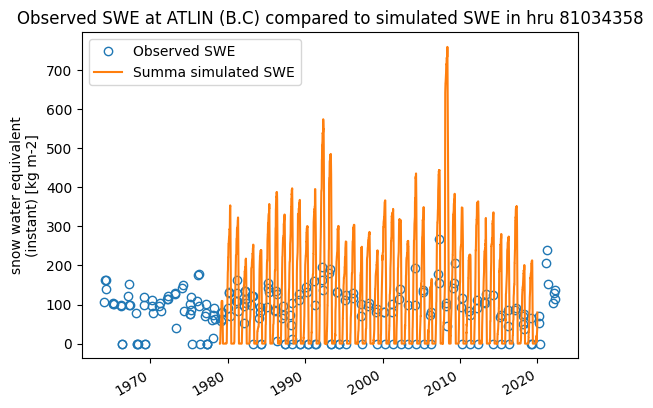

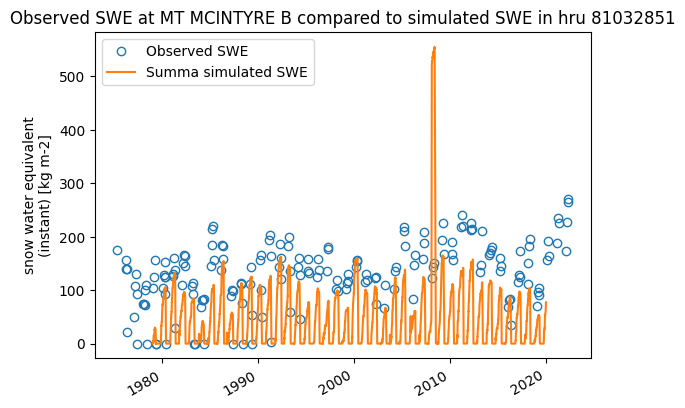

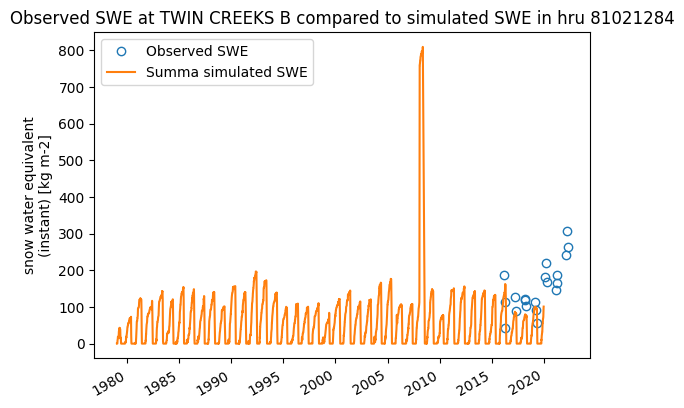

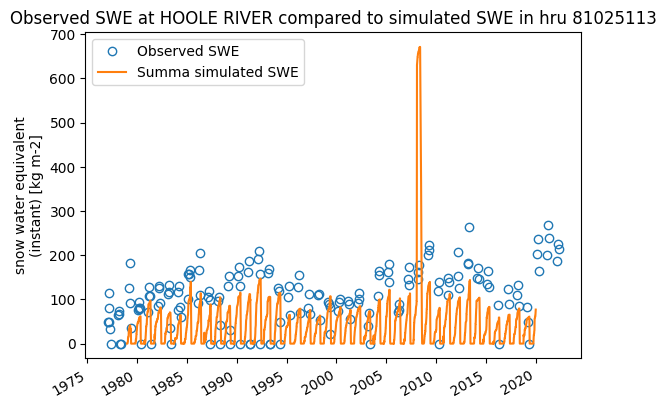

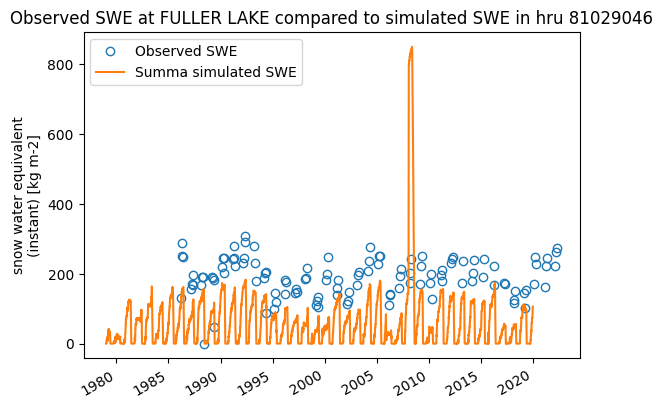

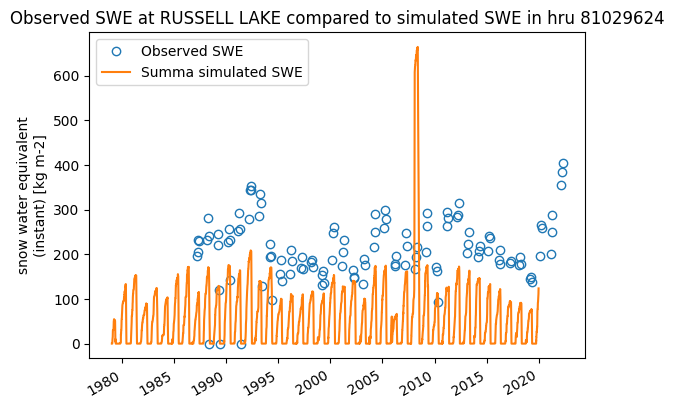

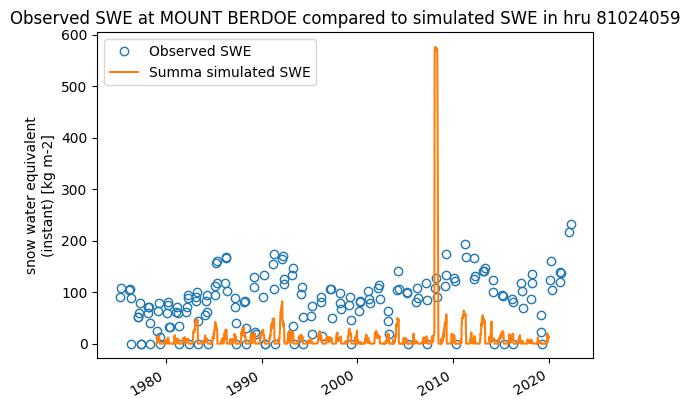

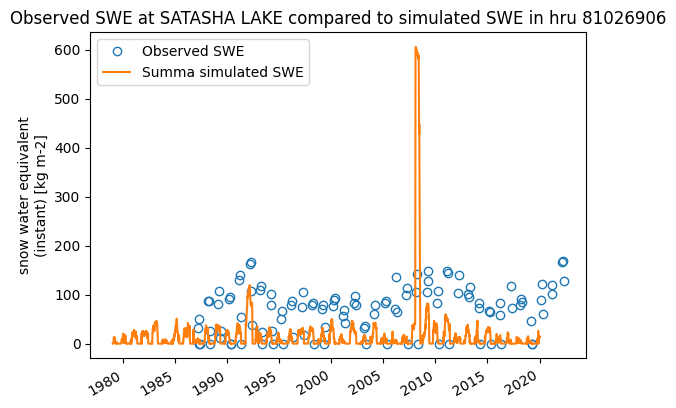

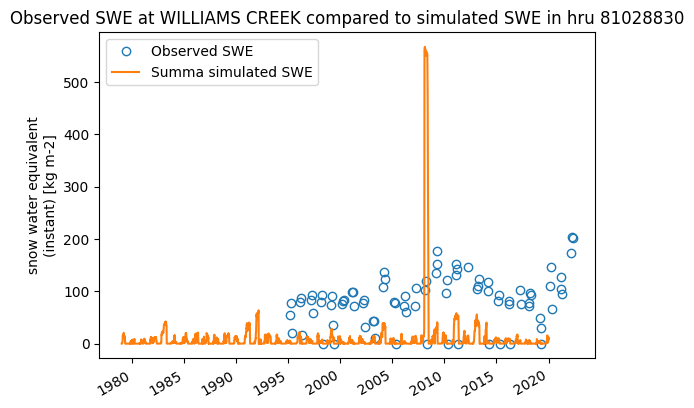

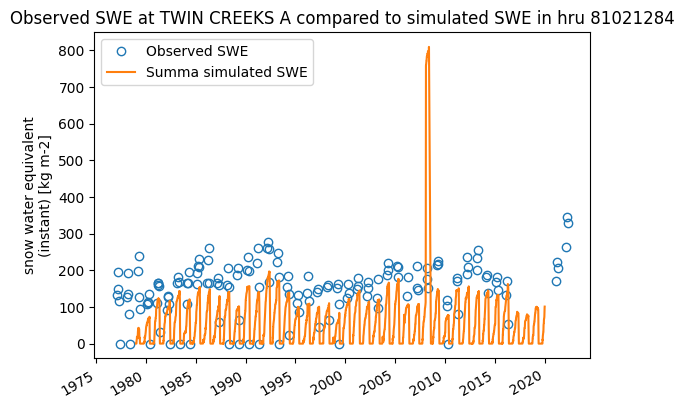

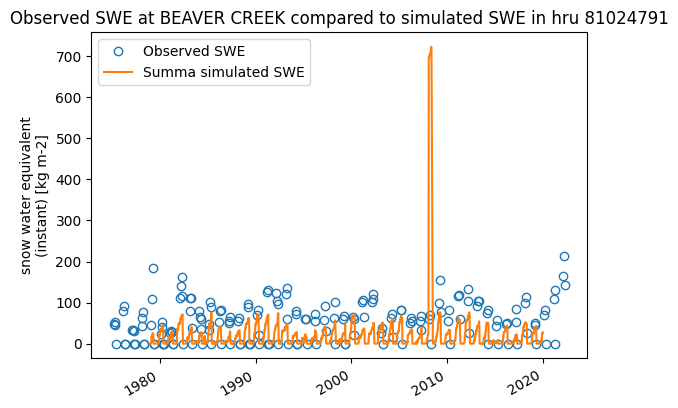

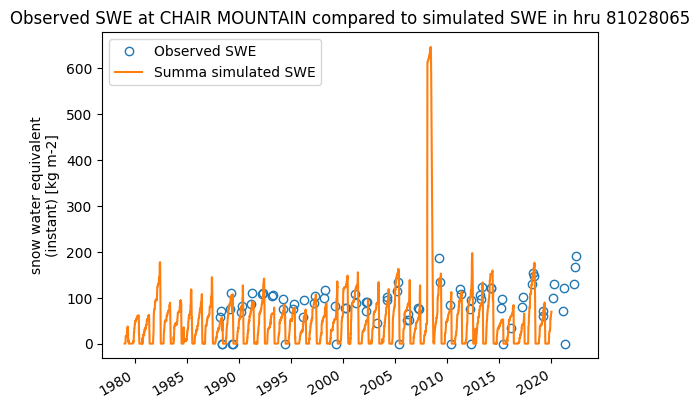

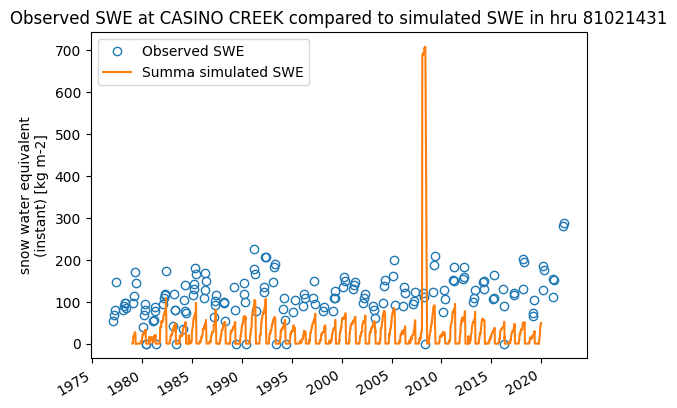

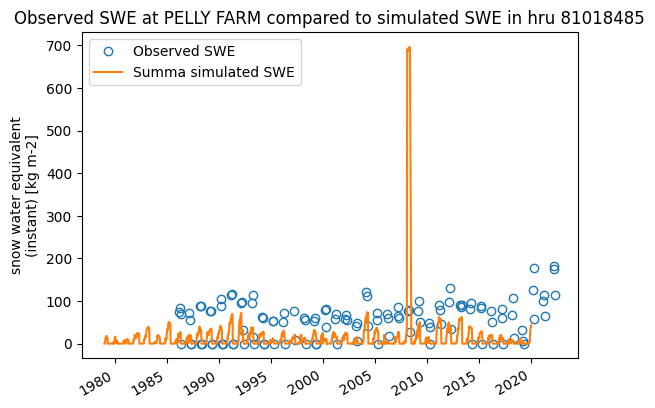

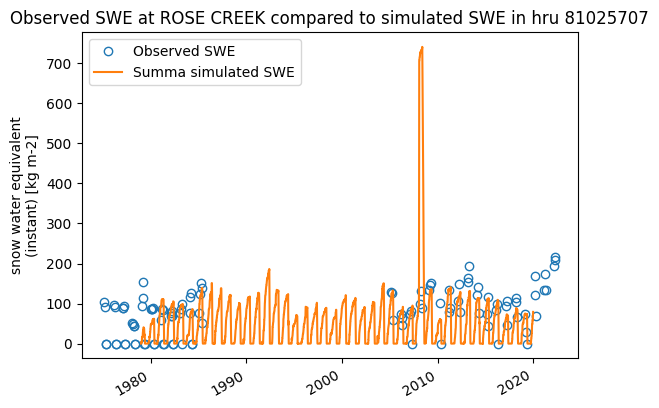

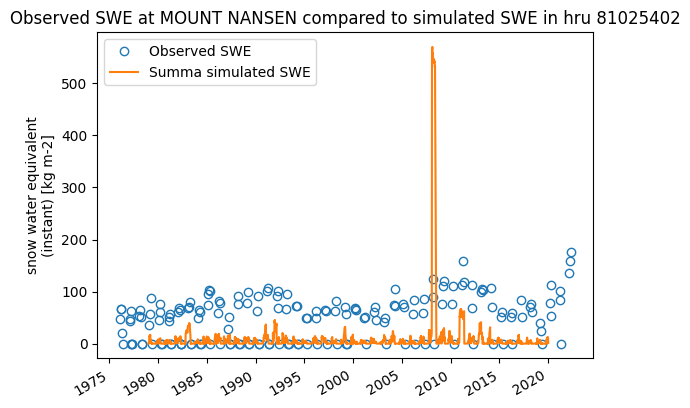

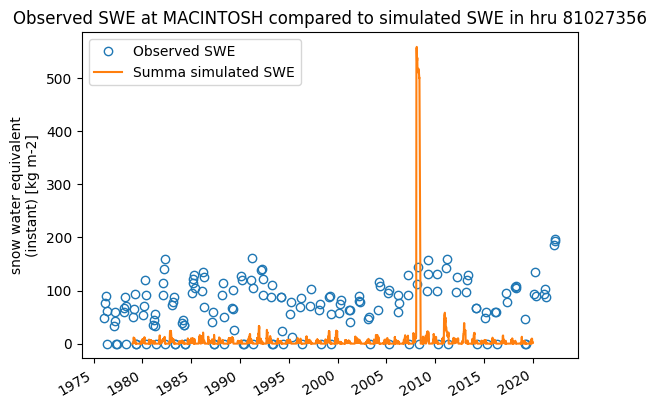

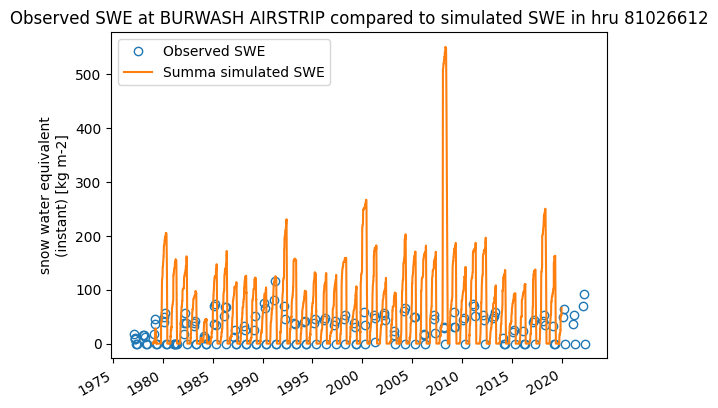

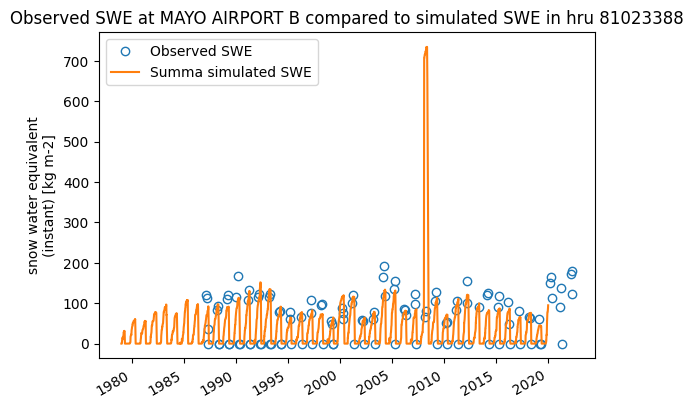

In [57]:
for i in range(0,len(ds_snow_list.index)-1):
    fig,ax = plt.subplots()
    row = ds_snow_list.iloc[i]
    #for row in ds_snow_list.iterrows():
    
    basin = row['COMID']
    station_id = row['station_id']
    station_name = row['station_na']
    summa_sim_SWE = summa['scalarSWE'].sel(hru = basin)
    
    if row['Country'] == 'USA':    
        station_dir_path = '/Users/darrieythorsson/compHydro/data/CWARHM_data/domain_Yukon/observations/SNOTEL/'
        for file in os.listdir(station_dir_path):
            if fnmatch.fnmatch(file, '*' + station_id + '.txt'):
                file_path = station_dir_path + file
                #file_path = file_path.replace(" ", "_")
                ds_station = pd.read_csv(file_path, skiprows = 60, index_col = 'Date')
        
        ds_station.index = pd.to_datetime(ds_station.index)
        
        ds_station['Snow Water Equivalent (in) Start of Day Values'].multiply(25.4).plot(ax = ax, label = 'SNOTEL observed SWE')
        summa_sim_SWE.plot(ax = ax, label = 'Summa simulated SWE')
        
    
    if row['Country'] == 'CAN':
        can_swe_path = '/Users/darrieythorsson/compHydro/data/CWARHM_data/domain_Yukon/observations/CAN_SWE/7734616/CanSWE-CanEEN_1928-2022_v5.csv'
        ds_station = pd.read_csv(can_swe_path, low_memory = False, index_col = 'time')
        ds_station = ds_station[ds_station['station_id'] == station_id]
        ds_station.index = pd.to_datetime(ds_station.index)
    
        ds_station['snw'].plot(ax = ax, marker = 'o', mfc = 'none', linestyle = '', label = 'CanSWE observed SWE')
        summa_sim_SWE.plot(ax = ax, label = 'Summa simulated SWE')

    
    ax.set_title('Observed SWE at ' + station_name + ' compared to simulated SWE in hru ' + str(basin))    
    ax.legend(loc = 'best')
    ax.set_xlabel('')
    save_path = '/Users/darrieythorsson/compHydro/data/CWARHM_data/domain_Yukon/evaluation/scalarSWE_vs_obsSWE_' + station_id + '.png'
    fig.savefig(save_path)

    